# Trend Prediction Model

In [1]:
import yfinance as yf
import pandas as pd
import ta
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Fetch Nasdaq-100 stock data
print("Downloading data for Nasdaq-100...")
df = yf.download('^NDX', start='1979-12-26', end='2024-06-21', auto_adjust=True)
print("Data downloaded successfully.")

# Calculate technical indicators
print("Calculating technical indicators...")
df['EMA_50'] = ta.trend.ema_indicator(df['Close'], window=50)
df['EMA_200'] = ta.trend.ema_indicator(df['Close'], window=200)
df['RSI'] = ta.momentum.rsi(df['Close'])
df['MACD'] = ta.trend.macd(df['Close'])
df['MACD_Signal'] = ta.trend.macd_signal(df['Close'])
df['MACD_Hist'] = ta.trend.macd_diff(df['Close'])

# Fill NaN values (if any)
df = df.fillna(method='bfill').fillna(method='ffill')

# Create season column
df['Month'] = df.index.month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
df['Season'] = df['Month'].apply(get_season)
df = pd.get_dummies(df, columns=['Season'], drop_first=True)

# Explanation:
# - We download the stock data for Nasdaq-100.
# - Calculate various technical indicators using the `ta` library.
# - Fill any NaN values in the dataset.
# - Create a season column to represent the month as a season.


[*********************100%%**********************]  1 of 1 completed

Data downloaded successfully.
Calculating technical indicators...


In [3]:
# Define features and target
features = ['Open', 'High', 'Low', 'Volume', 'EMA_50', 'EMA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'Season_Spring', 'Season_Summer', 'Season_Winter']
X = df[features]
y = df['Close']

# Create classification target
print("Creating classification task...")
y_class = pd.cut(df['Close'].pct_change().shift(-1), bins=[-np.inf, -0.00467, 0.00467, np.inf], labels=['Crash', 'No Change', 'Rally'])
y_class = y_class.dropna()

# Encode labels
label_encoder = LabelEncoder()
y_class_encoded = label_encoder.fit_transform(y_class)

# Explanation:
# - We define the features that will be used for the model.
# - The target variable is the closing price.
# - For classification, we create bins to categorize the stock trends into 'Crash', 'No Change', and 'Rally'.
# - The labels are encoded for the classification task.

Creating classification task...


In [7]:
# Split data into training and testing sets for classification task
X_class = X.loc[y_class.index]
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class_encoded, test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_class_encoded), y=y_class_encoded)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Apply SMOTE for over-sampling
smote = SMOTE(random_state=42)
X_class_train_resampled, y_class_train_resampled = smote.fit_resample(X_class_train, y_class_train)

# Scale the resampled data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_class_train_resampled_scaled = scaler_X.fit_transform(X_class_train_resampled)
X_class_test_scaled = scaler_X.transform(X_class_test)

# Reshape for LSTM
time_step = 1  # As we are using LSTM, we need to reshape the data accordingly
X_class_train_resampled_scaled = X_class_train_resampled_scaled.reshape((X_class_train_resampled_scaled.shape[0], time_step, X_class_train_resampled_scaled.shape[1]))
X_class_test_scaled = X_class_test_scaled.reshape((X_class_test_scaled.shape[0], time_step, X_class_test_scaled.shape[1]))

# Explanation:
# - Split the data into training and testing sets.
# - Scale the features to a range of [0, 1] for better performance in the LSTM model.
# - Reshape the data to fit the input shape required by the LSTM model.

In [36]:
# Initialize the LSTM model
model_class = Sequential()
model_class.add(LSTM(200, return_sequences=True, input_shape=(time_step, X_class_train_resampled_scaled.shape[2])))
model_class.add(LSTM(200, return_sequences=True))
model_class.add(Dropout(0.2))  # Adjust dropout rate
model_class.add(LSTM(100, return_sequences=False))
model_class.add(Dropout(0.2))  # Adjust dropout rate
model_class.add(Dense(50, activation='relu'))
model_class.add(Dense(3, activation='softmax'))

# Compile the model with adjusted learning rate
optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
model_class.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with intermediate result printing
history = model_class.fit(
    X_class_train_resampled_scaled, 
    y_class_train_resampled, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_class_test_scaled, y_class_test), 
    callbacks=[early_stopping], 
    verbose=1
)

# Explanation:
# - We initialize the LSTM model with two LSTM layers and a dropout layer.
# - The output layer uses a softmax activation function to output probabilities for the three classes.
# - Compile the model using the Adam optimizer and sparse categorical cross-entropy loss.
# - Train the model using the training data.

Epoch 1/100
136/136 [==============================] - 7s 16ms/step - loss: 1.0985 - accuracy: 0.3421 - val_loss: 1.0962 - val_accuracy: 0.3555
Epoch 2/100
136/136 [==============================] - 1s 8ms/step - loss: 1.0910 - accuracy: 0.3706 - val_loss: 1.0935 - val_accuracy: 0.3607
Epoch 3/100
136/136 [==============================] - 1s 9ms/step - loss: 1.0779 - accuracy: 0.3938 - val_loss: 1.0895 - val_accuracy: 0.3888
Epoch 4/100
136/136 [==============================] - 1s 9ms/step - loss: 1.0684 - accuracy: 0.4001 - val_loss: 1.0839 - val_accuracy: 0.3909
Epoch 5/100
136/136 [==============================] - 1s 9ms/step - loss: 1.0652 - accuracy: 0.4023 - val_loss: 1.0874 - val_accuracy: 0.3863
Epoch 6/100
136/136 [==============================] - 1s 9ms/step - loss: 1.0659 - accuracy: 0.4004 - val_loss: 1.0869 - val_accuracy: 0.3893
Epoch 7/100
136/136 [==============================] - 1s 10ms/step - loss: 1.0661 - accuracy: 0.4048 - val_loss: 1.0835 - val_accuracy: 0.38

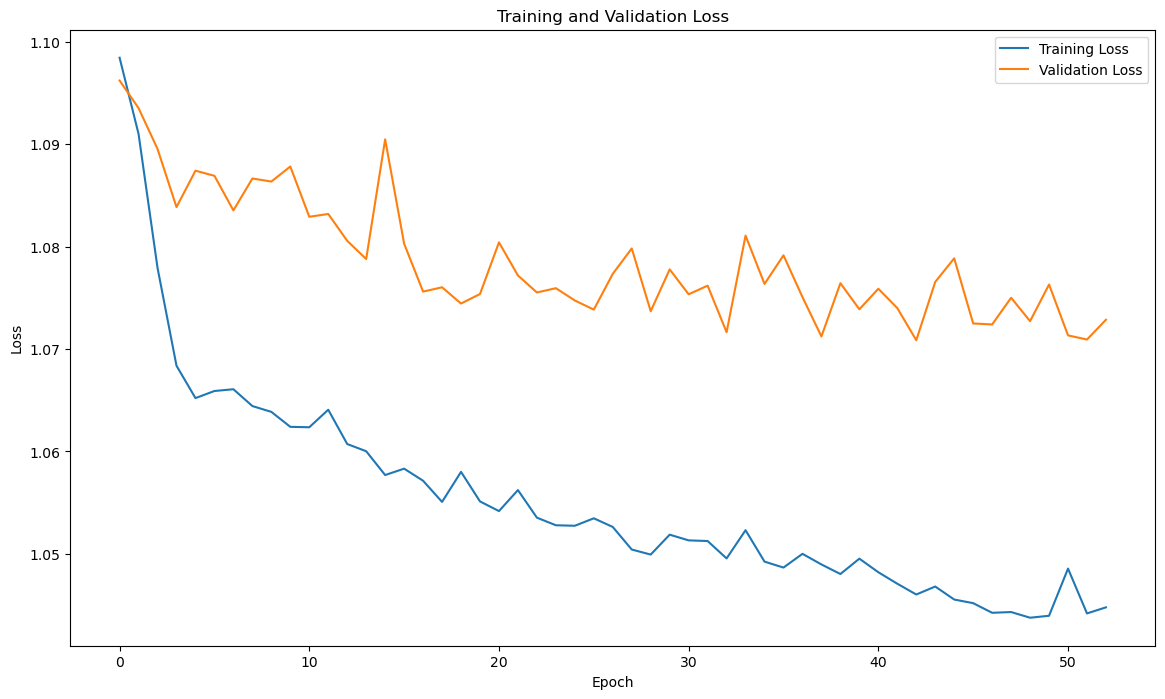

In [37]:
# Plot training and validation loss
plt.figure(figsize=(14, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
# Make predictions on the test set
y_class_pred_probs = model_class.predict(X_class_test_scaled)
y_class_pred_labels = np.argmax(y_class_pred_probs, axis=1)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_class_test, y_class_pred_labels)
print("Accuracy:", accuracy)

# Display the classification report
print("Classification Report:")
print(classification_report(y_class_test, y_class_pred_labels, target_names=label_encoder.classes_))

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_class_test, y_class_pred_labels))

61/61 [==============================] - 1s 2ms/step
Accuracy: 0.4057377049180328
Classification Report:
              precision    recall  f1-score   support

       Crash       0.38      0.29      0.33       597
   No Change       0.45      0.53      0.49       678
       Rally       0.37      0.39      0.38       677

    accuracy                           0.41      1952
   macro avg       0.40      0.40      0.40      1952
weighted avg       0.40      0.41      0.40      1952

Confusion Matrix:
[[174 189 234]
 [110 356 212]
 [172 243 262]]


In [39]:
# Make predictions
print("Making classification predictions...")
y_class_pred_proba = model_class.predict(X_class_test_scaled)  # Use predict for probability predictions
y_class_pred_labels = np.argmax(y_class_pred_proba, axis=1)  # Convert the predicted probabilities to class labels

print("Sample probability predictions:")
# Ensure the shape matches by using the correct label encoding classes
sample_proba_predictions = pd.DataFrame(y_class_pred_proba, columns=['Crash', 'No Change', 'Rally'])  # Manually specify column names
print(sample_proba_predictions.head(10))

# Explanation:
# - Use `predict` to get the predicted probabilities on the test set.
# - Convert the predicted probabilities to class labels using `argmax`.
# - Display a sample  of the predicted probabilities.


Making classification predictions...
61/61 [==============================] - 0s 2ms/step
Sample probability predictions:
      Crash  No Change     Rally
0  0.394435   0.223613  0.381952
1  0.345304   0.304834  0.349861
2  0.342136   0.298277  0.359586
3  0.264633   0.361447  0.373920
4  0.259661   0.393372  0.346967
5  0.336584   0.292381  0.371036
6  0.419632   0.205258  0.375110
7  0.311643   0.375325  0.313032
8  0.258914   0.449995  0.291091
9  0.346593   0.272349  0.381058


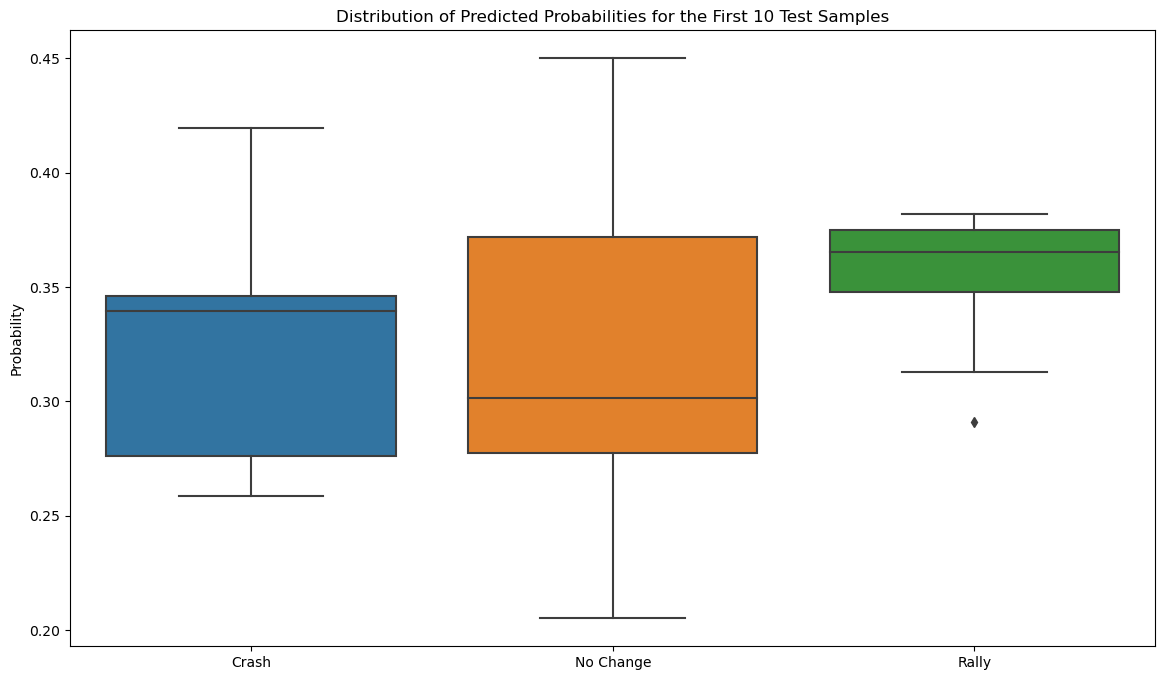

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the sample probabilities to a DataFrame for easier manipulation
sample_proba_predictions_df = pd.DataFrame(y_class_pred_proba[:10], columns=label_encoder.classes_)

# Plot the probabilities
plt.figure(figsize=(14, 8))
sns.boxplot(data=sample_proba_predictions_df)
plt.title('Distribution of Predicted Probabilities for the First 10 Test Samples')
plt.ylabel('Probability')
plt.show()

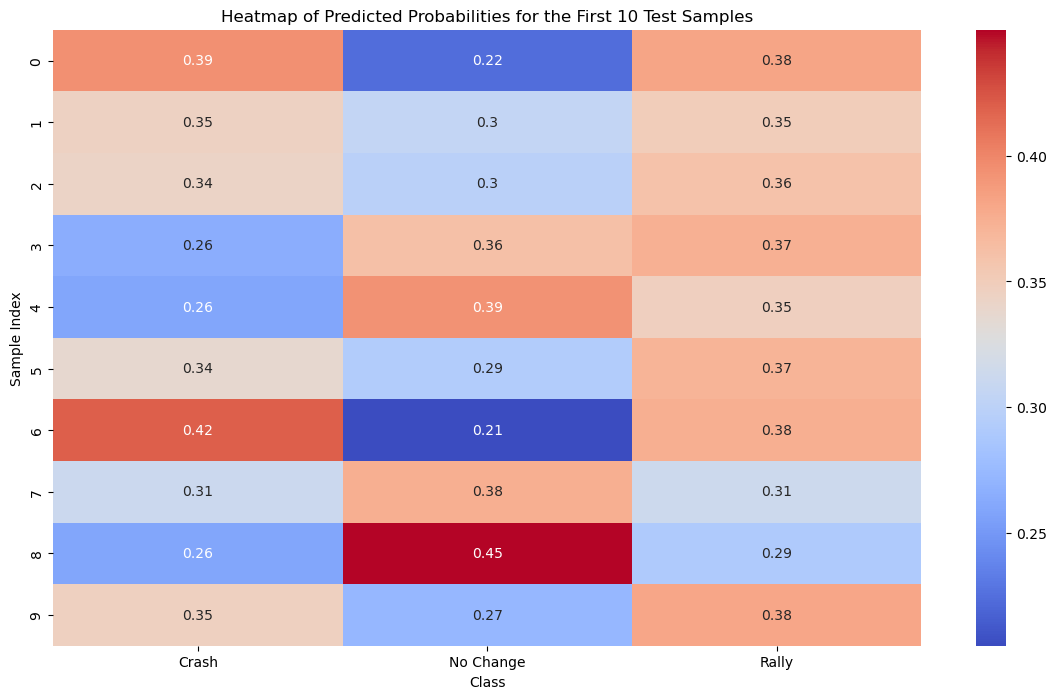

In [41]:
plt.figure(figsize=(14, 8))
sns.heatmap(sample_proba_predictions_df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap of Predicted Probabilities for the First 10 Test Samples')
plt.xlabel('Class')
plt.ylabel('Sample Index')
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate classification model
print("Evaluating classification model...")
accuracy = accuracy_score(y_class_test, y_class_pred_labels)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_class_test, y_class_pred_labels, target_names=label_encoder.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_class_test, y_class_pred_labels))

# Explanation:
# - Calculate the accuracy of the model.
# - Display the classification report, which includes precision, recall, and F1-score for each class.
# - Display the confusion matrix to see the performance of the model in classifying each category.

Evaluating classification model...
Accuracy: 0.4057377049180328
Classification Report:
              precision    recall  f1-score   support

       Crash       0.38      0.29      0.33       597
   No Change       0.45      0.53      0.49       678
       Rally       0.37      0.39      0.38       677

    accuracy                           0.41      1952
   macro avg       0.40      0.40      0.40      1952
weighted avg       0.40      0.41      0.40      1952

Confusion Matrix:
[[174 189 234]
 [110 356 212]
 [172 243 262]]


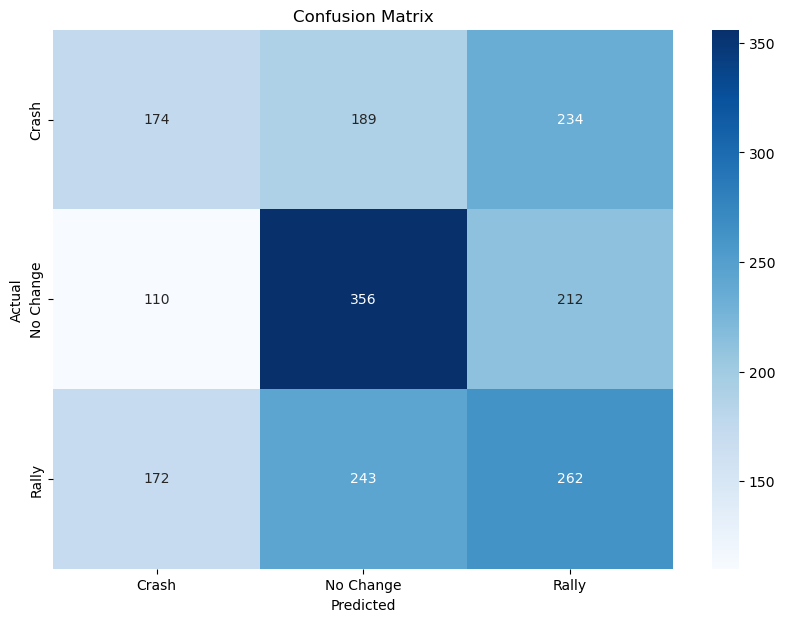

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_class_test, y_class_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Explanation:
# - Plot the confusion matrix using a heatmap for better visualization.
# - The heatmap will show the number of correct and incorrect predictions for each class.
